In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

import LinearResponseVariationalBayes.ModelSensitivity as model_sens

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

In [2]:
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha3.5_iris.json')
# json_input_file = os.path.join(
#     git_repo,
#    'BNP_sensitivity/GMM_clustering/iris_fits/',
#    filename)

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)
    prior_param_vec0 = model.prior_params.get_vector()
    
moment_model = gmm_utils.InterestingMoments(model)


In [3]:
alpha0 = model.prior_params['alpha'].get()
print(alpha0)

[3.5]


In [4]:
# this is analagous to the moment model, but for expected number of clusters
e_num_clusters_class = gmm_utils.ExpectedNumClusters(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param)

# linear_sensitivity = \
#     obj_lib.ParametricSensitivity(\
#         objective_fun =             model.set_z_get_kl,\
#         input_par =                 model.global_vb_params,\
#         output_par =                e_num_clusters_class.e_num_clusters,\
#         hyper_par =                 model.prior_params,\
#         input_to_output_converter = e_num_clusters_class.set_e_num_clusters,\
#         optimal_input_par =         best_param,\
#         objective_hessian =         kl_hessian)


linear_sensitivity = \
    model_sens.ParametricSensitivityTaylorExpansion(\
        objective_functor =         model.set_z_get_kl,\
        input_par =                 model.global_vb_params,\
        hyper_par =                 model.prior_params,\
        input_val0 = best_param, 
        hyper_val0 = prior_param_vec0, 
        order = 2, 
        hess0 = kl_hessian)


In [5]:
print(model.prior_params)

def refit_with_alpha(new_alpha, model, linear_sens, prior_param_vec0):
    model.prior_params['alpha'].set(new_alpha)
    model.objective.logger.initialize()
    model.objective.logger.print_every = 10
    
    dhyper = model.prior_params.get_vector() - prior_param_vec0
    
    free_par_refit = \
        linear_sensitivity.evaluate_taylor_series(dhyper)
        
    model.optimize_full(free_par_refit, bfgs_init=False)
    return free_par_refit, model.global_vb_params.get_free()


prior_params:
	alpha: [3.5]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [6]:
alpha_vec = np.array([4.0]) # np.linspace(0.5, 6.5, num=13)

print(alpha_vec)
free_par_refit_list = []
free_par_refit_lr_list = []
for alpha in alpha_vec:
    print(alpha)
    free_par_refit_lr, free_par_refit = \
        refit_with_alpha(alpha, model, linear_sensitivity, prior_param_vec0)
    free_par_refit_list.append(free_par_refit)
    free_par_refit_lr_list.append(free_par_refit_lr)


[4.]
4.0


NotImplementedError: JVP of slogdet wrt argnums (0,) not defined

In [7]:
len(best_param)

190

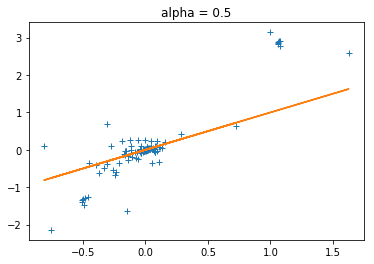

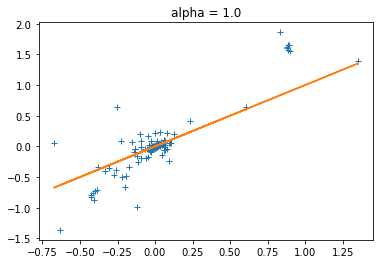

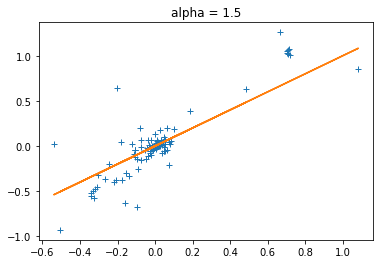

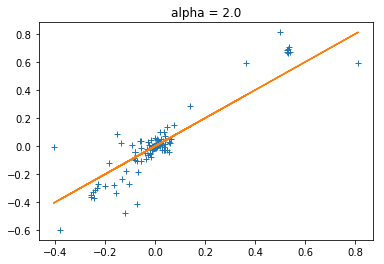

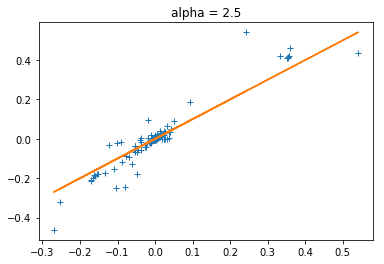

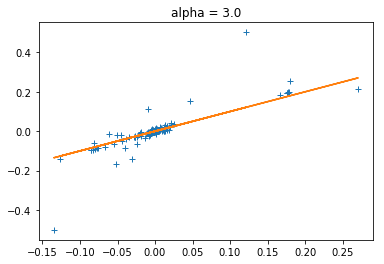

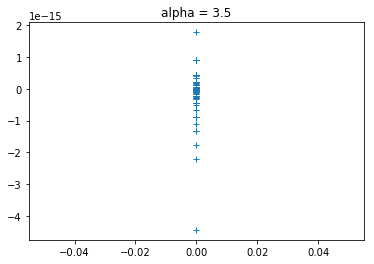

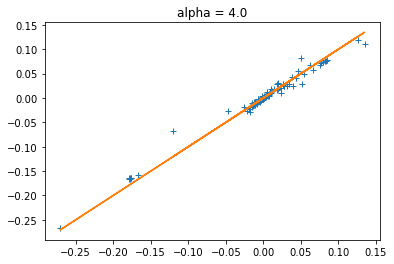

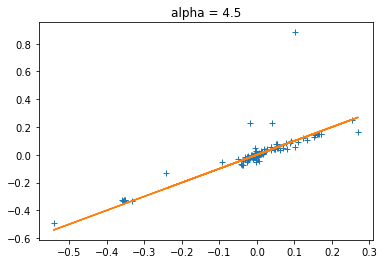

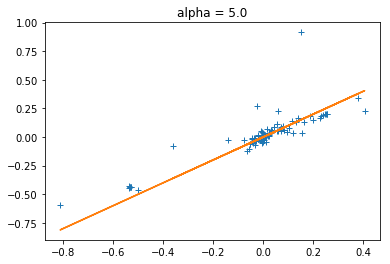

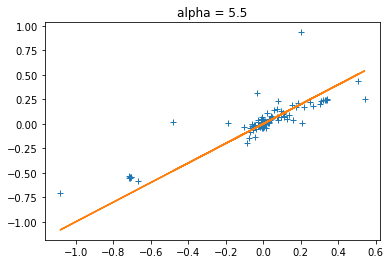

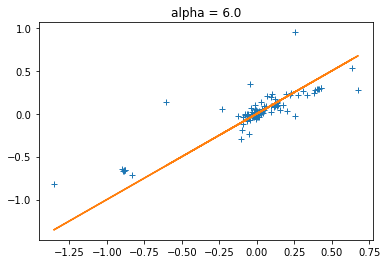

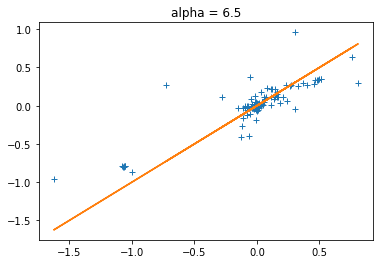

In [8]:
for i in range(len(free_par_refit_list)): 
    plt.figure()
    plt.plot(free_par_refit_lr_list[i]- best_param, free_par_refit_list[i] - best_param, '+')
    plt.plot(free_par_refit_lr_list[i]- best_param, free_par_refit_lr_list[i]- best_param, '-')
    plt.title('alpha = {}'.format(alpha_vec[i]))

In [9]:
alpha_vec[i]

6.5

In [10]:
e_num_clusters_pred = []
e_num_clusters_true = []
for i in range(len(alpha_vec)): 
    e_num_clusters_true.append(
            e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(free_par_refit_list[i]))
    
    model.prior_params['alpha'].set(alpha_vec[i])
    pert_prior_vec = model.prior_params.get_vector()
    e_num_clusters_pred.append(
        linear_sensitivity.predict_output_par_from_hyperparameters(pert_prior_vec, linear = False))

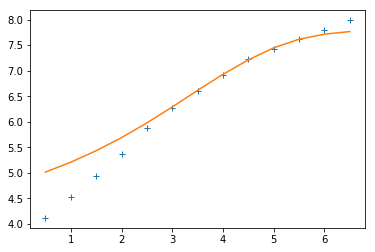

In [11]:
plt.plot(alpha_vec, e_num_clusters_true, '+')
plt.plot(alpha_vec, e_num_clusters_pred, '-')

In [12]:
np.save('alpha_vec_start3_5', alpha_vec)

In [13]:
np.save('e_num_clusters_true_start3_5', e_num_clusters_true)

In [14]:
np.save('e_num_clusters_pred_start3_5', e_num_clusters_pred)

In [31]:
e_num_clusters_true = np.load('./e_num_clusters_true_start5.npy')
e_num_clusters_pred = np.load('./e_num_clusters_pred_start5.npy')
alpha_vec = np.load('./alpha_vec_start3_5.npy')

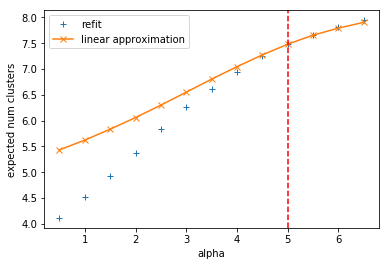

In [32]:
plt.plot(alpha_vec, e_num_clusters_true, '+')
plt.plot(alpha_vec, e_num_clusters_pred, 'x-')

plt.axvline(x=5., linestyle = '--', color = 'red')

plt.xlabel('alpha')
plt.ylabel('expected num clusters')

plt.legend(('refit', 'linear approximation'))

plt.savefig('../../../writing/NIPS_2018_BNP_workshop/parametric_sens_results/pred_num_clusters_init_alpha5.png')